# Clustering of RedPy

This notebook will use RedPy feature data and cluster it to try and find patterns

Originally developed by Marine Denolle on Dec 7, 2023

Most recent edits by Nick Smoczyk on Dec 14, 2023

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score, silhouette_samples


Scaling: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html

In [93]:
#from https://stackoverflow.com/questions/57340166/how-to-plot-the-pricipal-vectors-of-each-variable-after-performing-pca
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]

    plt.scatter(xs ,ys, s=10) #without scaling
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'black', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'black', ha = 'center', va = 'center')

#get ncom from idealv if ncom == 'auto'
def ncom_idealv(ncom_list,idealv,X): #ncom_list is list of options, idealv is ideal variance, x is the data
    sum_list = [] #will be a list of cumulative explained variance ratio for each ncom
    for n_com in ncom_list:
        
        pca = PCA(n_components=n_com) #get the pca function
        scaler = StandardScaler().set_output(transform="pandas")
        scaled_X = scaler.fit_transform(X) #normalize data for scaling
        
        pca.fit(scaled_X) #use pca on data X
        x_new = pca.transform(scaled_X)
        print(x_new.shape)
        
#         myplot(x_new[:,0:2], pca.components_.T) 
#         plt.show()
#         plt.close()

        vr = pca.explained_variance_ratio_
        sum_list.append(sum(vr))
        
        
        #plot explained varience
#         plt.bar(x=np.arange(0,len(vr),1),height=vr)
# #         plt.yscale('log') #in case drop in vr with each component is large
#         plt.show()
#         plt.close()
        
        print(f'{n_com} components -> {sum(vr)} variance ratio')


    diff_list = [abs(i-idealv) for i in sum_list] #find difference from idealv across ncom_list
    #look through ncom_list to find the ncom closest to idealv
    ncom = ncom_list[diff_list.index(min(diff_list))] #get the minimum difference, find its index, pull from ncom_list
    
    plt.scatter(x=ncom_list,y=sum_list,color='black')
    
    print('auto ncom =',ncom)
    return ncom

### Data
Read TSFEL features for Mt Rainier

In [7]:
# this is some underway data collected from a cruise in 2019
mt_rainier = pd.read_csv('../../../expand_redpy_new_files/Rainier_tsfel_features.csv')

In [8]:
df = mt_rainier.copy()
df.dropna(inplace=True)
df.head()

,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_2,0_FFT mean coefficient_3,0_FFT mean coefficient_4,0_FFT mean coefficient_5,0_FFT mean coefficient_6,0_FFT mean coefficient_7,0_FFT mean coefficient_8,0_FFT mean coefficient_9,...,0_Negative turning points,0_Neighbourhood peaks,0_Peak to peak distance,0_Positive turning points,0_Signal distance,0_Slope,0_Sum absolute diff,0_Total energy,0_Zero crossing rate,template
0,4.251313e-08,3.932619e-09,2.286470e-08,6.950114e-08,5.496805e-08,9.462838e-08,1.951158e-07,1.805888e-07,6.700315e-07,7.928933e-07,...,629.0,154.0,1.758302,629.0,3522.662216,-9.628687e-10,37.499908,0.050993,869.0,CC_CARB_rpra_3
1,4.604560e-06,4.716205e-07,2.300050e-06,4.298284e-06,9.119836e-06,5.211722e-06,1.902368e-05,6.879704e-05,9.970790e-05,2.684652e-04,...,565.0,146.0,1.353356,565.0,3521.700855,7.334546e-08,55.134123,0.076039,649.0,CC_CARB_rpra_13
2,6.488920e-06,1.218434e-05,9.122074e-05,2.063236e-04,1.632531e-04,2.301393e-04,1.516768e-04,3.398730e-04,2.478204e-04,1.907248e-04,...,519.0,160.0,1.560520,520.0,3523.520318,6.422047e-08,89.323884,0.259117,592.0,CC_CARB_rpra_50
3,3.887297e-07,1.676714e-07,7.242766e-07,1.159509e-06,1.636281e-06,1.428913e-05,1.535842e-05,3.739341e-05,5.299815e-05,5.868771e-05,...,580.0,158.0,1.566193,581.0,3523.753620,-5.574950e-09,74.410709,0.153993,702.0,CC_CARB_rpra_63
4,1.897318e-06,3.443066e-07,1.035059e-06,4.135231e-06,6.097145e-06,1.443698e-05,2.915572e-05,4.521000e-05,1.366167e-04,6.646028e-05,...,493.0,154.0,1.645998,493.0,3523.056006,-7.569077e-09,77.935979,0.142795,690.0,CC_CARB_rpra_130


In [9]:
# df.dropna(axis=1, inplace=True)
df.drop(['template'], axis=1, inplace=True)


In [10]:
df.isna().sum().any()   

False

In [ ]:
df.corr().style.background_gradient(cmap='coolwarm')

(6515, 2)
2 components -> 0.3551227802711407 variance ratio
(6515, 3)
3 components -> 0.43580856497324405 variance ratio
(6515, 4)
4 components -> 0.48302937811173885 variance ratio
(6515, 5)
5 components -> 0.5246975076450198 variance ratio
(6515, 8)
8 components -> 0.5848690109795709 variance ratio
(6515, 10)
10 components -> 0.614078568142123 variance ratio
(6515, 12)
12 components -> 0.6387531056103164 variance ratio
(6515, 20)
20 components -> 0.7046373342917573 variance ratio
(6515, 20)
20 components -> 0.7046742415564008 variance ratio
(6515, 40)
40 components -> 0.7907843280418719 variance ratio
(6515, 50)
50 components -> 0.8200665477071415 variance ratio
auto ncom = 50


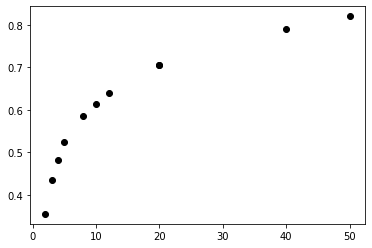

In [94]:
#PCA component analysis

numcom = ncom_idealv(ncom_list=[2,3,4,5,8,10,12,20,20,40,50],idealv=0.86,X=df.to_numpy())

Are some of the features log-normal? Log-normal features will be wrongly scaled for a euclidian distance.

We will select the features of high skewness.

In [87]:
# Step 1: Calculate skewness for each feature
skewness = df.apply(lambda x: x.skew())

# Step 2: Identify features with high positive skewness (right-skewed)
log_normal_features = skewness[skewness > 1.0].index.tolist()

In [9]:
print(len(log_normal_features))
print(len(df.keys()))

315
389


Most features are log normal. OK transform all log-normal features.


In [88]:
df_log = df.copy()
df_log[log_normal_features] = np.log(df_log[log_normal_features]) # log transform the skewed features

# drop the features with Nan, Inf, Zeros from the data frames.
df_log.dropna(inplace=True,axis=1)
df_log.replace([np.inf, -np.inf], np.nan, inplace=True)
df_log.dropna(inplace=True,axis=1)
df_log.replace(0, np.nan)
df_log.dropna(inplace=True,axis=1)
df_log.isna().sum().any()

/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


False

In [89]:
df_log.describe()

,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_2,0_FFT mean coefficient_3,0_FFT mean coefficient_4,0_FFT mean coefficient_5,0_FFT mean coefficient_6,0_FFT mean coefficient_7,0_FFT mean coefficient_8,0_FFT mean coefficient_9,...,0_Median diff,0_Negative turning points,0_Neighbourhood peaks,0_Peak to peak distance,0_Positive turning points,0_Signal distance,0_Slope,0_Sum absolute diff,0_Total energy,0_Zero crossing rate
count,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,...,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6.515000e+03,6515.000000,6515.000000,6515.000000
mean,-12.743238,-15.345523,-14.575970,-13.769526,-13.173658,-12.478220,-11.719486,-10.974422,-10.340000,-9.763446,...,0.000023,594.792939,157.297160,1.526802,594.794014,8.167996,-1.254934e-09,4.586574,-1.415198,787.147199
std,1.642272,1.974336,2.407802,2.716968,2.816512,2.794359,2.694302,2.591389,2.454974,2.316831,...,0.000459,95.827043,12.081627,0.318528,95.828254,0.001386,1.443374e-07,0.531384,0.714317,194.687814
min,-20.100126,-23.137120,-23.160586,-23.344524,-22.848641,-21.899463,-21.149857,-20.166389,-19.521439,-18.201534,...,-0.003633,161.000000,55.000000,0.158674,162.000000,8.166245,-1.285112e-06,2.253204,-4.577387,222.000000
25%,-13.770824,-16.630117,-16.223526,-15.707866,-15.180335,-14.421095,-13.517429,-12.685546,-11.970570,-11.287977,...,-0.000165,522.000000,151.000000,1.352103,522.000000,8.167111,-4.884986e-08,4.229505,-1.893760,655.000000
50%,-12.617677,-15.327039,-14.650262,-13.697725,-12.969886,-12.277096,-11.527056,-10.816658,-10.160007,-9.600791,...,0.000010,592.000000,159.000000,1.615972,592.000000,8.167638,-4.580292e-10,4.617336,-1.395466,750.000000
75%,-11.561515,-14.035635,-12.821313,-11.730923,-11.036123,-10.343348,-9.677674,-9.027681,-8.513231,-8.011934,...,0.000198,663.000000,166.000000,1.767834,663.000000,8.168442,4.942604e-08,4.972158,-0.914413,901.000000
max,-8.316038,-7.938689,-7.152044,-6.941554,-6.557002,-5.785443,-4.892830,-4.118747,-4.499866,-4.279980,...,0.003976,1062.000000,208.000000,1.996956,1062.000000,8.180609,1.159162e-06,6.074296,0.849753,1690.000000


Here we notice that the features have extremely different values. It seems difficult to continue with normal kmeans because the Euclidian distance will be inadequate.

(6515, 2)
2 components -> 0.5711490568144675 variance ratio
(6515, 3)
3 components -> 0.6819084785325005 variance ratio
(6515, 4)
4 components -> 0.7384977984309318 variance ratio
(6515, 5)
5 components -> 0.7608530947471093 variance ratio
(6515, 8)
8 components -> 0.7950074423403549 variance ratio
(6515, 10)
10 components -> 0.8098789627227959 variance ratio
(6515, 12)
12 components -> 0.8213755681654972 variance ratio
(6515, 20)
20 components -> 0.8523073997808793 variance ratio
(6515, 30)
30 components -> 0.8809445088220911 variance ratio
(6515, 40)
40 components -> 0.9014740039585195 variance ratio
(6515, 50)
50 components -> 0.91713182539531 variance ratio
auto ncom = 20


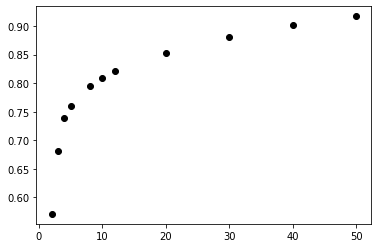

In [95]:
#PCA component analysis on log transformed

numcom = ncom_idealv(ncom_list=[2,3,4,5,8,10,12,20,30,40,50],idealv=0.86,X=df_log.to_numpy())

In [ ]:
#pca with auto ncom



Let's try some standard scaling first

In [12]:
# scaler = preprocessing.StandardScaler().fit(X_pca)
# Initialize the StandardScaler
scaler = StandardScaler()
# Fit and transform the DataFrame using StandardScaler
df_log_scaled = pd.DataFrame(scaler.fit_transform(df_log), columns=df_log.columns)
X_scaled = df_log_scaled.to_numpy()

## 3. K-means

In [13]:
# Example on original data with silhouette score
X = df.to_numpy()
ncluster=4
kmeans_model = KMeans(n_clusters=ncluster, random_state=1).fit(X)
labels = kmeans_model.labels_
sc=silhouette_score(X, labels, metric='euclidean')
print(f"Silhouette score for {ncluster} clusters: {sc:.3f}")

/home/smocz/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for 4 clusters: 0.529


In [15]:
#add labels (clusterID) to csv
mt_rainier['clusterID']=labels
mt_rainier.head()

,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_2,0_FFT mean coefficient_3,0_FFT mean coefficient_4,0_FFT mean coefficient_5,0_FFT mean coefficient_6,0_FFT mean coefficient_7,0_FFT mean coefficient_8,0_FFT mean coefficient_9,...,0_Neighbourhood peaks,0_Peak to peak distance,0_Positive turning points,0_Signal distance,0_Slope,0_Sum absolute diff,0_Total energy,0_Zero crossing rate,template,clusterID
0,4.251313e-08,3.932619e-09,2.286470e-08,6.950114e-08,5.496805e-08,9.462838e-08,1.951158e-07,1.805888e-07,6.700315e-07,7.928933e-07,...,154.0,1.758302,629.0,3522.662216,-9.628687e-10,37.499908,0.050993,869.0,CC_CARB_rpra_3,2
1,4.604560e-06,4.716205e-07,2.300050e-06,4.298284e-06,9.119836e-06,5.211722e-06,1.902368e-05,6.879704e-05,9.970790e-05,2.684652e-04,...,146.0,1.353356,565.0,3521.700855,7.334546e-08,55.134123,0.076039,649.0,CC_CARB_rpra_13,2
2,6.488920e-06,1.218434e-05,9.122074e-05,2.063236e-04,1.632531e-04,2.301393e-04,1.516768e-04,3.398730e-04,2.478204e-04,1.907248e-04,...,160.0,1.560520,520.0,3523.520318,6.422047e-08,89.323884,0.259117,592.0,CC_CARB_rpra_50,0
3,3.887297e-07,1.676714e-07,7.242766e-07,1.159509e-06,1.636281e-06,1.428913e-05,1.535842e-05,3.739341e-05,5.299815e-05,5.868771e-05,...,158.0,1.566193,581.0,3523.753620,-5.574950e-09,74.410709,0.153993,702.0,CC_CARB_rpra_63,0
4,1.897318e-06,3.443066e-07,1.035059e-06,4.135231e-06,6.097145e-06,1.443698e-05,2.915572e-05,4.521000e-05,1.366167e-04,6.646028e-05,...,154.0,1.645998,493.0,3523.056006,-7.569077e-09,77.935979,0.142795,690.0,CC_CARB_rpra_130,0


In [16]:
# mt_rainier.to_csv('Rainier_tsfel_features_clustered_kmeans.csv')

Example on log-transformed data (AND scaling) with silhouette score

In [110]:
X = df_log.to_numpy()
ncluster=6

### PCA WITH SCALING ###
# pca = PCA(n_components=numcom) #get the pca function
# scaler = StandardScaler().set_output(transform="pandas")
# scaled_X = scaler.fit_transform(X) #normalize data for scaling

# pca.fit(scaled_X) #use pca on data X
# x_new = pca.transform(scaled_X)

### PCA NO SCALING ###

pca = PCA(n_components=numcom) #get the pca function

pca.fit(X) #use pca on data X
x_new = pca.transform(X)

#kmeans
kmeans_model = KMeans(n_clusters=ncluster, random_state=1).fit(x_new)
labels = kmeans_model.labels_
sc=silhouette_score(x_new, labels, metric='euclidean')
print(f"Silhouette score for {ncluster} clusters: {sc:.3f}")

/home/smocz/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for 6 clusters: 0.524


In [111]:
#add labels (clusterID) to csv
save_df = pd.DataFrame(data=[])
save_df['template']=mt_rainier['template'].values.tolist()
save_df['clusterID']=labels
save_df.head()

,template,clusterID
0,CC_CARB_rpra_3,5
1,CC_CARB_rpra_13,2
2,CC_CARB_rpra_50,3
3,CC_CARB_rpra_63,2
4,CC_CARB_rpra_130,2


In [112]:
# save_df.to_csv('Rainier_log_scale_pca_kmeans.csv')

/home/smocz/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4, the average silhouette_score is : 0.529


Text(0.5, 0.98, 'Silhouette analysis for KMeans clustering on sample data with n_clusters = 4')

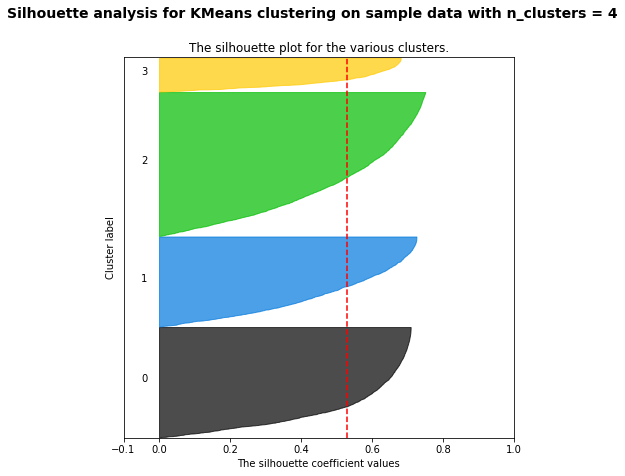

In [109]:
ncluster=4
import matplotlib.cm as cm
fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(7, 7)
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (ncluster + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clusterer = KMeans(n_clusters=ncluster, random_state=10)
cluster_labels = clusterer.fit_predict(X)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print(f"For n_clusters = {ncluster}, the average silhouette_score is : {silhouette_avg:.3f}")

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(ncluster):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / ncluster)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % ncluster,
    fontsize=14,
    fontweight="bold",
)



In [35]:
mt_rainier['clusterID'] = clusterID
mt_rainier.to_csv('../data/Rainier_tsfel_features_clustered_kmeans.csv')

NameError: name 'clusterID' is not defined

### 3. Choice of number of clusters: The Elbow Method


Compute the value of E for different values of the number of clusters

/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2, the average silhouette_score is : 0.200


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 3, the average silhouette_score is : 0.172


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4, the average silhouette_score is : 0.160


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 5, the average silhouette_score is : 0.156


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6, the average silhouette_score is : 0.156


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 7, the average silhouette_score is : 0.142


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 8, the average silhouette_score is : 0.131


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 9, the average silhouette_score is : 0.121


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 10, the average silhouette_score is : 0.113


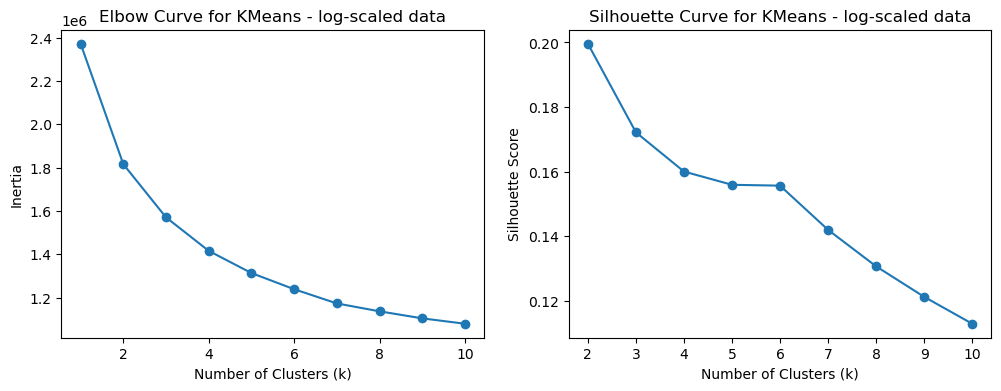

In [54]:
X = df_log_scaled.to_numpy()
# Elbow method  
inertia = []
silhouette_avg=[]
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    cluster_labels = kmeans.labels_
    inertia.append(kmeans.inertia_)
    if k>=2:
        silhouette_avg.append(silhouette_score(X, cluster_labels))
        print(f"For n_clusters = {k}, the average silhouette_score is : {silhouette_avg[-1]:.3f}")


fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(range(1, 11), inertia, marker='o')
ax[0].set_title('Elbow Curve for KMeans - log-scaled data')
ax[0].set_xlabel('Number of Clusters (k)')
ax[0].set_ylabel('Inertia')
ax[1].plot(range(2, 11), silhouette_avg, marker='o')
ax[1].set_title('Silhouette Curve for KMeans - log-scaled data')
ax[1].set_xlabel('Number of Clusters (k)')
ax[1].set_ylabel('Silhouette Score')
plt.show()

/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2, the average silhouette_score is : 0.581


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 3, the average silhouette_score is : 0.545


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4, the average silhouette_score is : 0.529


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 5, the average silhouette_score is : 0.534


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6, the average silhouette_score is : 0.525


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 7, the average silhouette_score is : 0.526


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 8, the average silhouette_score is : 0.526


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 9, the average silhouette_score is : 0.530


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 10, the average silhouette_score is : 0.524


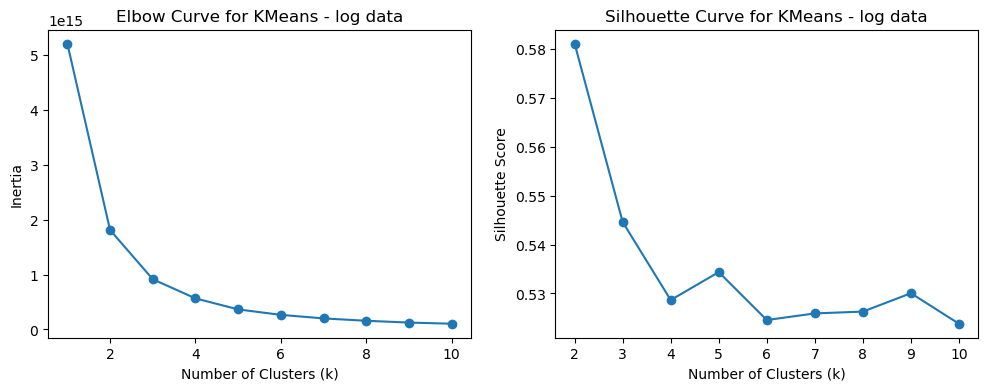

In [55]:
X = df_log.to_numpy()
# Elbow method  
inertia = []
silhouette_avg=[]
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    cluster_labels = kmeans.labels_
    inertia.append(kmeans.inertia_)
    if k>=2:
        silhouette_avg.append(silhouette_score(X, cluster_labels))
        print(f"For n_clusters = {k}, the average silhouette_score is : {silhouette_avg[-1]:.3f}")


fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(range(1, 11), inertia, marker='o')
ax[0].set_title('Elbow Curve for KMeans - log data')
ax[0].set_xlabel('Number of Clusters (k)')
ax[0].set_ylabel('Inertia')
ax[1].plot(range(2, 11), silhouette_avg, marker='o')
ax[1].set_title('Silhouette Curve for KMeans - log data')
ax[1].set_xlabel('Number of Clusters (k)')
ax[1].set_ylabel('Silhouette Score')
plt.show()

/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2, the average silhouette_score is : 0.581


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 3, the average silhouette_score is : 0.545


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4, the average silhouette_score is : 0.529


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 5, the average silhouette_score is : 0.534


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6, the average silhouette_score is : 0.525


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 7, the average silhouette_score is : 0.526


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 8, the average silhouette_score is : 0.526


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 9, the average silhouette_score is : 0.530


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 10, the average silhouette_score is : 0.524


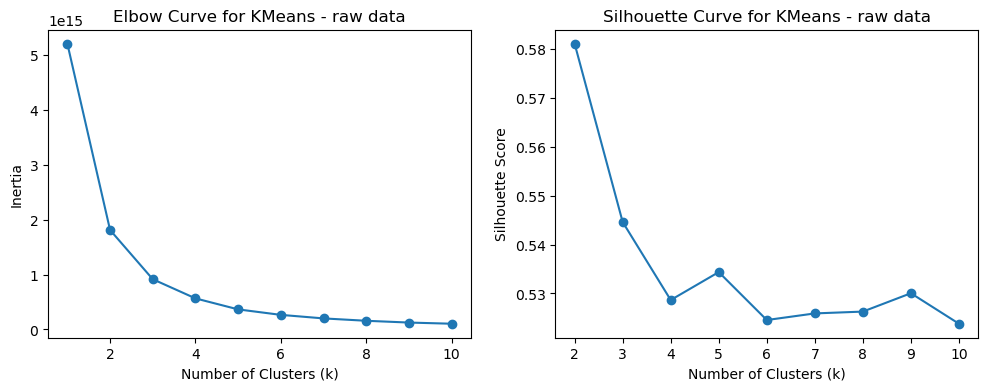

In [56]:
X = df.to_numpy()
# Elbow method  
inertia = []
silhouette_avg=[]
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    cluster_labels = kmeans.labels_
    inertia.append(kmeans.inertia_)
    if k>=2:
        silhouette_avg.append(silhouette_score(X, cluster_labels))
        print(f"For n_clusters = {k}, the average silhouette_score is : {silhouette_avg[-1]:.3f}")


fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(range(1, 11), inertia, marker='o')
ax[0].set_title('Elbow Curve for KMeans - raw data')
ax[0].set_xlabel('Number of Clusters (k)')
ax[0].set_ylabel('Inertia')
ax[1].plot(range(2, 11), silhouette_avg, marker='o')
ax[1].set_title('Silhouette Curve for KMeans - raw data')
ax[1].set_xlabel('Number of Clusters (k)')
ax[1].set_ylabel('Silhouette Score')
plt.show()

## 4. Hierarchical Clustering

In K-means, we use the euclidian distance and prescribe the number of clusters K.

In hierarchical clustering, we choose difference distance metrics, visualize the data structure, and then decide on the number of clusters. There are two approaches to building the hierarchy of clusters:

* **Agglomerative**: each point starts in each unique cluster. data is merged in pairs as on creates a hierarchy of clusters.
* **Divisive**: initially, all data is into 1 cluster. The data is recursively split into smaller and smaller clusters.


There are several types of *linkages*. sklearn has detailed [documentation](!https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering), mostly for agglomerative: The different linkages methods are:

* **Ward** minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.
* **Maximum** or complete linkage minimizes the maximum distance between observations of pairs of clusters.
* **Average** linkage minimizes the average of the distances between all observations of pairs of clusters.
* **Single** linkage minimizes the distance between the closest observations of pairs of clusters.

We first import relevant packages



In [57]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.cluster import hierarchy  #
from scipy.spatial.distance import pdist

rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

First we explore the dendograms

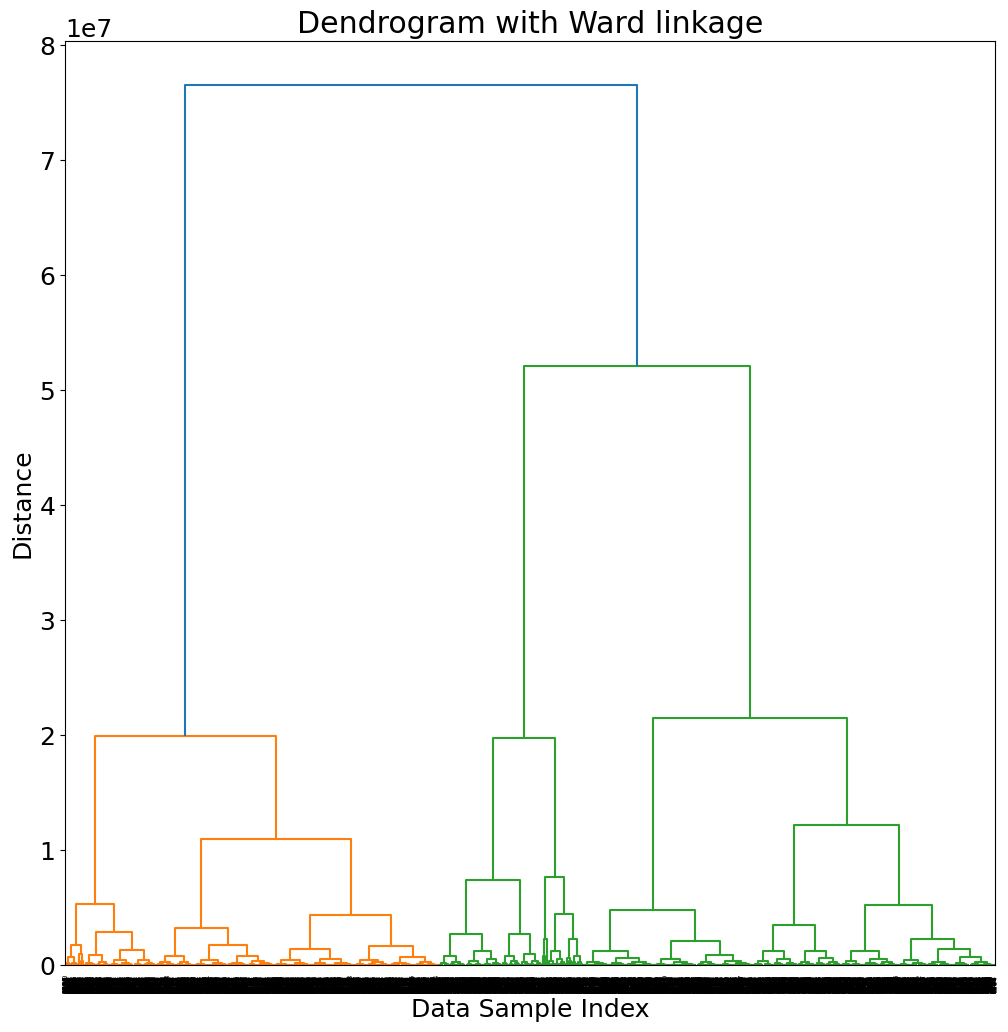

In [60]:
## Dendrograms on raw data
X = df.to_numpy()
Y = pdist(X,metric='euclidean')
Z = hierarchy.linkage(Y,method='ward')
thresh = 0.85*np.max(Z[:,2])

plt.figure()
dn = hierarchy.dendrogram(Z,p=100,color_threshold=thresh)
plt.xlabel('Data Sample Index')
plt.ylabel('Distance')
plt.title('Dendrogram with Ward linkage')
plt.show()

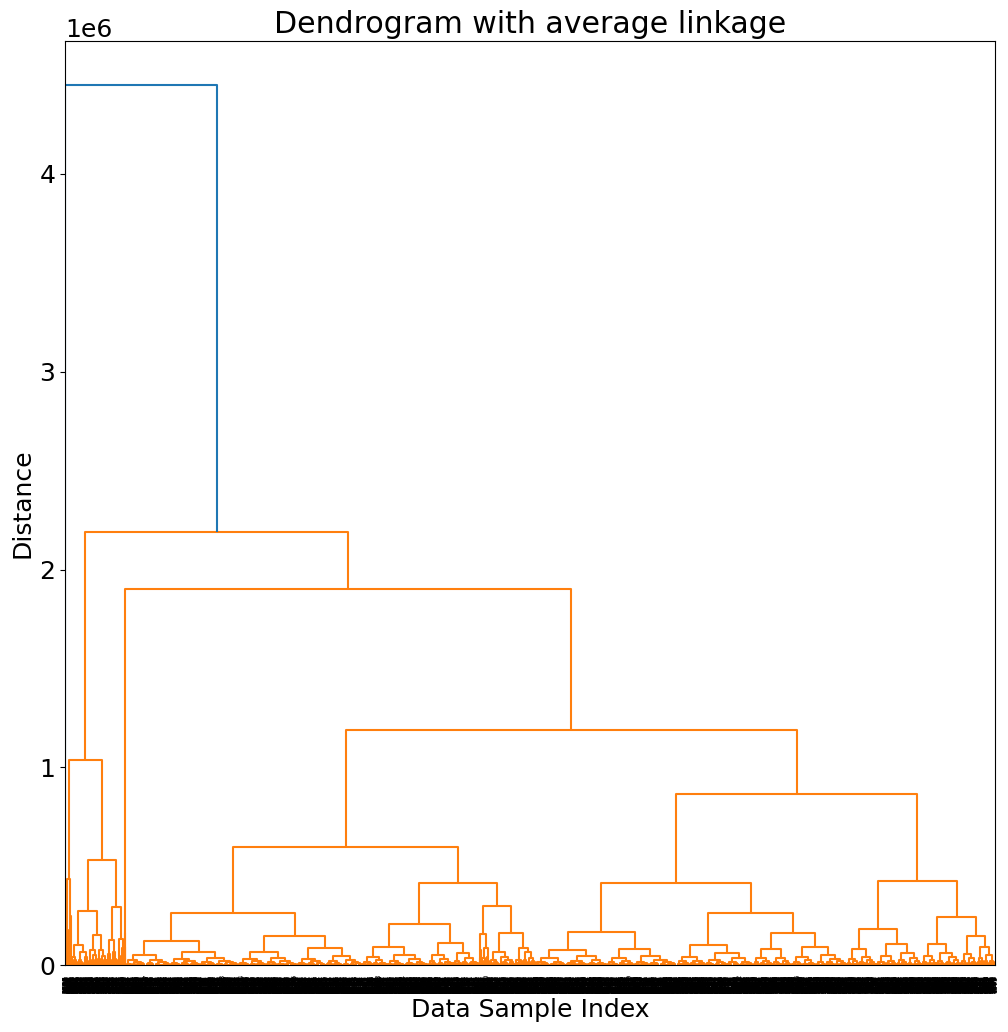

In [59]:
## Dendrograms on log data
X = df_log.to_numpy()
Y = pdist(X,metric='euclidean')
Z = hierarchy.linkage(Y,method='average')
thresh = 0.85*np.max(Z[:,2])

plt.figure()
dn = hierarchy.dendrogram(Z,p=100,color_threshold=thresh)
plt.xlabel('Data Sample Index')
plt.ylabel('Distance')
plt.title('Dendrogram with average linkage')
plt.show()

##

Now let's cluster:

* Ward linkage on raw feature
* ward linkage on log features
* ward linkage on log and scaled features


In [68]:
from sklearn.cluster import AgglomerativeClustering
X=df.to_numpy()
# Let's first find a reasonable distance threshod by precalculating the linkage matrix
Z = hierarchy.linkage(X,method='ward')
thresh = 0.4*np.max(Z[:,2])    # choose a threshold distance
# design model
model = AgglomerativeClustering(distance_threshold=thresh,linkage="ward", n_clusters=None)
# fit model and predict clusters on the data samples
clusterID=model.fit_predict(X)
ncluster=len(np.unique(clusterID))
silhouette_avg = silhouette_score(X, clusterID)
print(f"For n_clusters = {ncluster}, the average silhouette_score is : {silhouette_avg:.3f}")


mt_rainier['clusterID'] = clusterID
mt_rainier.to_csv('../data/Rainier_tsfel_features_clustered_agg.csv')

For n_clusters = 3, the average silhouette_score is : 0.542


* Ward on log data

In [69]:
from sklearn.cluster import AgglomerativeClustering
X=df_log.to_numpy()
# Let's first find a reasonable distance threshod by precalculating the linkage matrix
Z = hierarchy.linkage(X,method='ward')
thresh = 0.4*np.max(Z[:,2])    # choose a threshold distance
# design model
model = AgglomerativeClustering(distance_threshold=thresh,linkage="ward", n_clusters=None)
# fit model and predict clusters on the data samples
clusterID=model.fit_predict(X)
ncluster=len(np.unique(clusterID))
silhouette_avg = silhouette_score(X, clusterID)
print(f"For n_clusters = {ncluster}, the average silhouette_score is : {silhouette_avg:.3f}")

mt_rainier['clusterID'] = clusterID
mt_rainier.to_csv('../data/Rainier_tsfel_features_clustered_agg_log.csv')

For n_clusters = 3, the average silhouette_score is : 0.542


* Ward on log-transformed data

In [71]:
from sklearn.cluster import AgglomerativeClustering
X=df_log_scaled.to_numpy()
# Let's first find a reasonable distance threshod by precalculating the linkage matrix
Z = hierarchy.linkage(X,method='ward')
thresh = 0.4*np.max(Z[:,2])    # choose a threshold distance
# design model
model = AgglomerativeClustering(distance_threshold=thresh,linkage="ward", n_clusters=None)
# fit model and predict clusters on the data samples
clusterID=model.fit_predict(X)
ncluster=len(np.unique(clusterID))
silhouette_avg = silhouette_score(X, clusterID)
print(f"For n_clusters = {ncluster}, the average silhouette_score is : {silhouette_avg:.3f}")

mt_rainier['clusterID'] = clusterID
mt_rainier.to_csv('../data/Rainier_tsfel_features_clustered_agg_log_scaled.csv')

For n_clusters = 5, the average silhouette_score is : 0.129


## Try PCA+normalization before clustering

What happens if we apply PCA + normalization before the clustering?

In [72]:
X = df.to_numpy()   
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

In [73]:
scaler = preprocessing.StandardScaler().fit(X_pca)
X_scaled = scaler.transform(X_pca)

In [74]:
# Let's first find a reasonable distance threshod by precalculating the linkage matrix
Z = hierarchy.linkage(X_scaled,method='ward')
thresh = 0.3*np.max(Z[:,2])    # choose a threshold distance

plt.figure()
dn = hierarchy.dendrogram(Z,p=100,color_threshold=thresh)
plt.xlabel('Data Sample Index')
plt.ylabel('Distance')
plt.title('Dendrogram with average linkage')
plt.show()
# design model
model = AgglomerativeClustering(distance_threshold=thresh,linkage="ward", n_clusters=None)
# fit model and predict clusters on the data samples
clusterID=model.fit_predict(X_scaled)
plt.hist(clusterID);


1.7299044867668667


In [ ]:
ncluster=len(np.unique(clusterID))
fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(18, 7)
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X) + (ncluster + 1) * 10])

silhouette_avg = silhouette_score(X_scaled, clusterID)
print(
    "For n_clusters =",
    ncluster,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_scaled, clusterID)

y_lower = 10
for i in range(ncluster):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[clusterID == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / ncluster)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % ncluster,
    fontsize=14,
    fontweight="bold",
)

